# Px Score Validation OS - Updated Risk
```{contents}
```

Here we will validate the CoxPH-Lasso model on the validation set. We will use the same hyperparameters as the ones found in the previous notebook.

## Where the data at?

In [1]:
import pandas as pd
import sys
sys.path.append('../')
from source.cox_lasso_functions import *

input_path = '/mnt/d/MethylScore/Intermediate_Files/'
output_path = '/mnt/d/MethylScore/Processed_Data/'
zhou2016_probes_path = '/mnt/d/MethylScore/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

## Load Data

In [2]:
raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs_newrisk.csv', index_col=0)

mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.99)

# Remove `'cg04092699'` from mean coefs
mean_coefs = mean_coefs.drop('cg04092699')

df_validation = pd.read_pickle(
    input_path+'201samples_357839cpgs_withbatchcorrection_bvalues.pkl').sort_index()[mean_coefs.index]

validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                       low_memory=False, index_col=0)

print(
    f' Dataset (df) contains {df_validation.shape[1]} columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Dataset (df) contains 47 columns (5mC nucleotides/probes) and 201 rows (samples).


## Transform to M-values

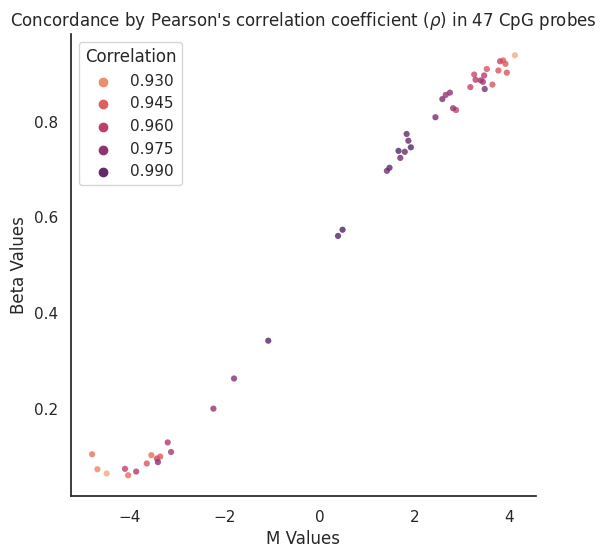

In [3]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_test_m = df_validation.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_test_m.corrwith(df_validation, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_test_m.mean(),df_validation.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.8,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=20)

## Standardize Data

Here we will use the same scaler as the one used in the previous notebook (discovery cohort).

In [4]:
def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df_z = (df - reference_df.mean()) / reference_df.std()

    return df_z

# Read top CpGs selected from previous code file (univariate cox-ph EWAS)
ewas_top_cpgs = pd.read_csv(output_path+'ewas_dmr/ewas_top_cpgs_os.csv', index_col=0)

# Standardize data
x_test_m_z = standardize_data(df= x_test_m, reference_df= ewas_top_cpgs)

## Generate Model Results

### Validation dataset

In [5]:
score_name = 'MethylScoreAML_Px'

df_test, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_test_m,
                                        df=validation_clinical_data,
                                        score_name=score_name,
                                        train_test=0.4934,
                                        rpart_outcome='os.time')


Continuous score cut at the value of 0.4934


Text(0.5, 1.0, 'Distribution of MethylScoreAML_Px in StJude trials')

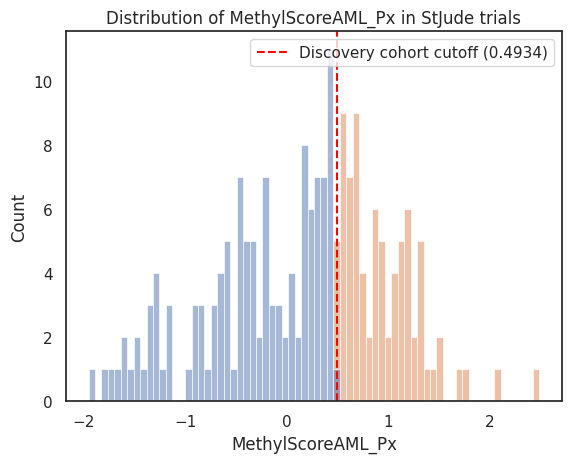

In [6]:
sns.histplot(data=df_test,x=score_name, bins=70, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')


# add legend
plt.legend({'Discovery cohort cutoff' + ' (' + str(threshold) + ')',})
plt.title('Distribution of ' + score_name + ' in StJude trials')

### Kaplan-Meier Plots

#### Overall study population

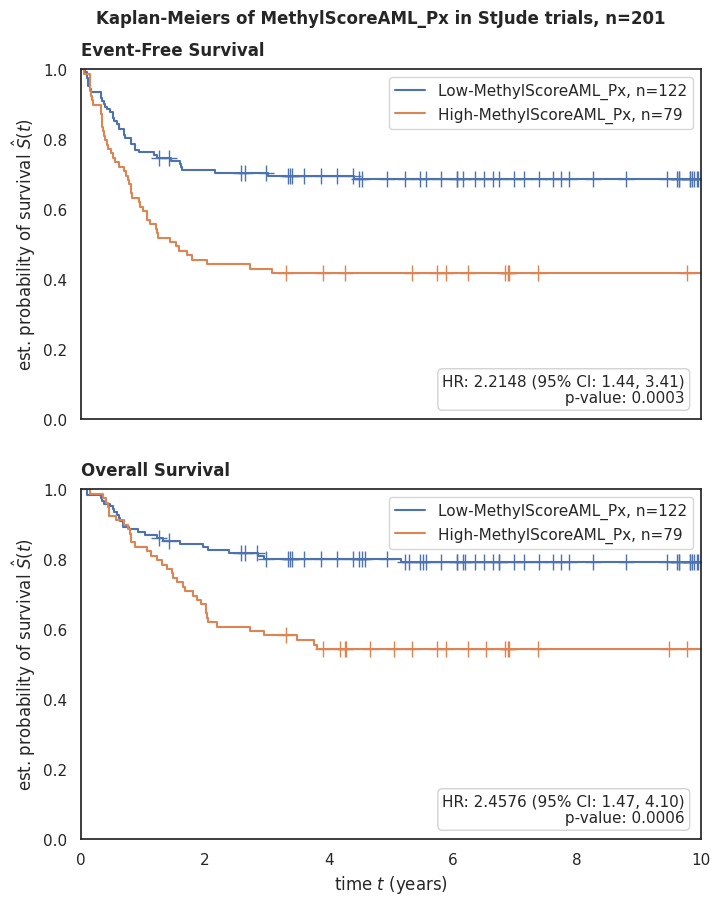

In [7]:
# Import Plotting Functions
from source.data_visualization_functions import *

draw_kaplan_meier(scorename=score_name,
                        df=df_test,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname='StJude trials')

#### Per risk group

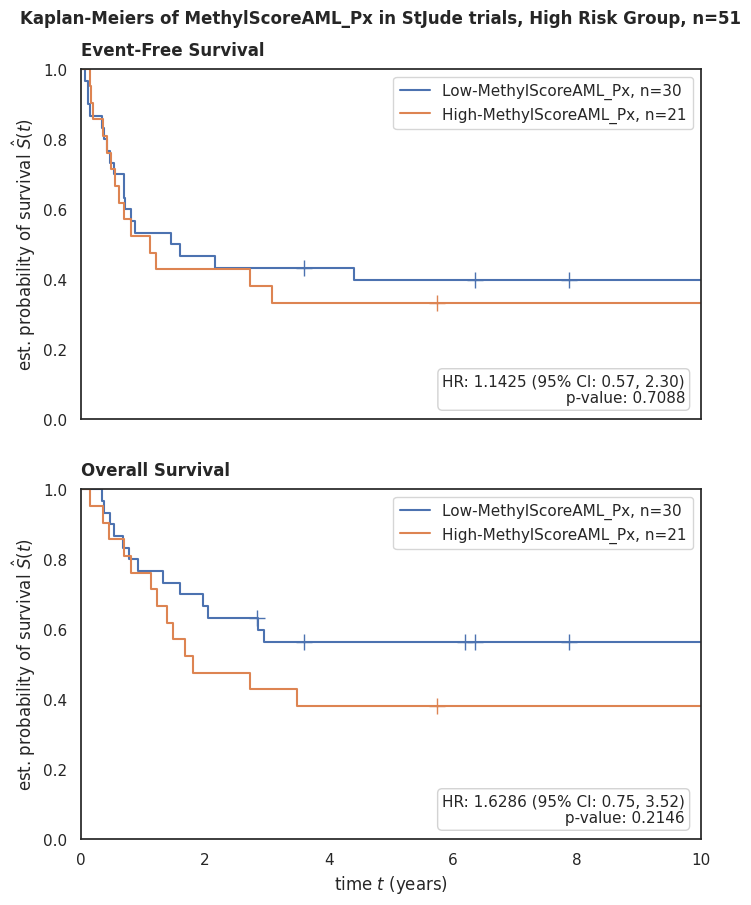

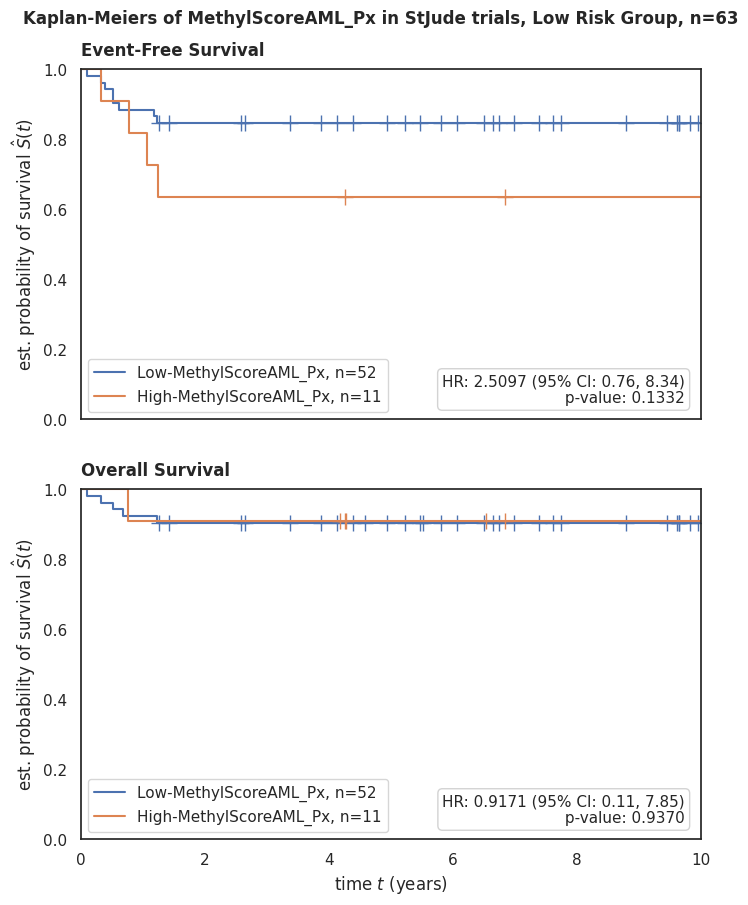

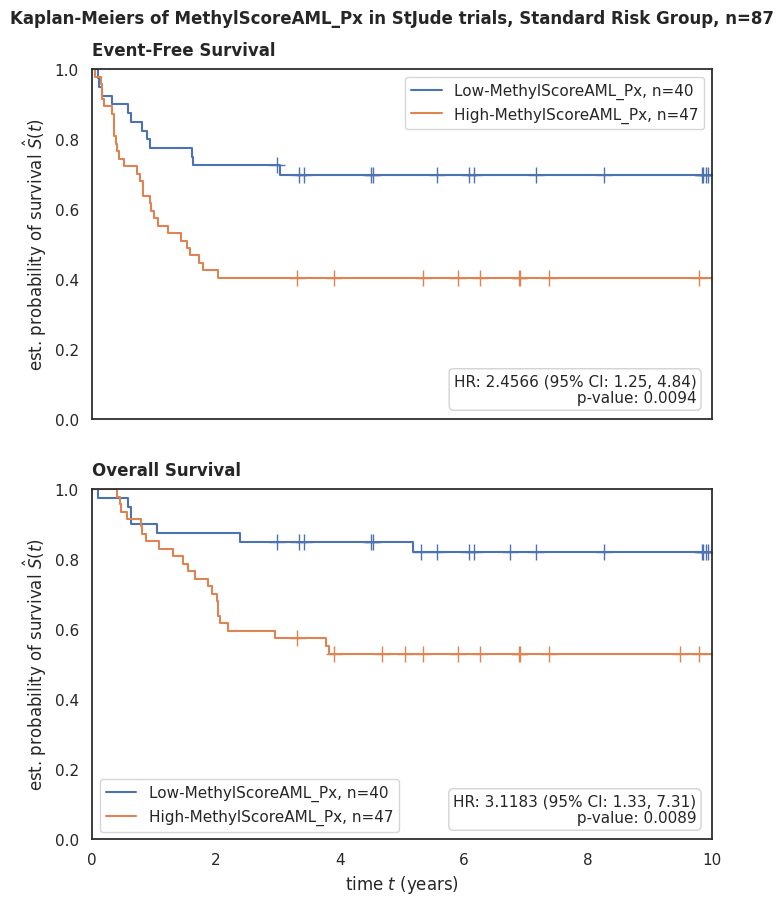

In [8]:
draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'High Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, High Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'Low Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Low Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'Standard Risk'],
                        save_plot=False,
                        save_survival_table=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Standard Risk Group')

### Forest Plots

#### With MRD 1

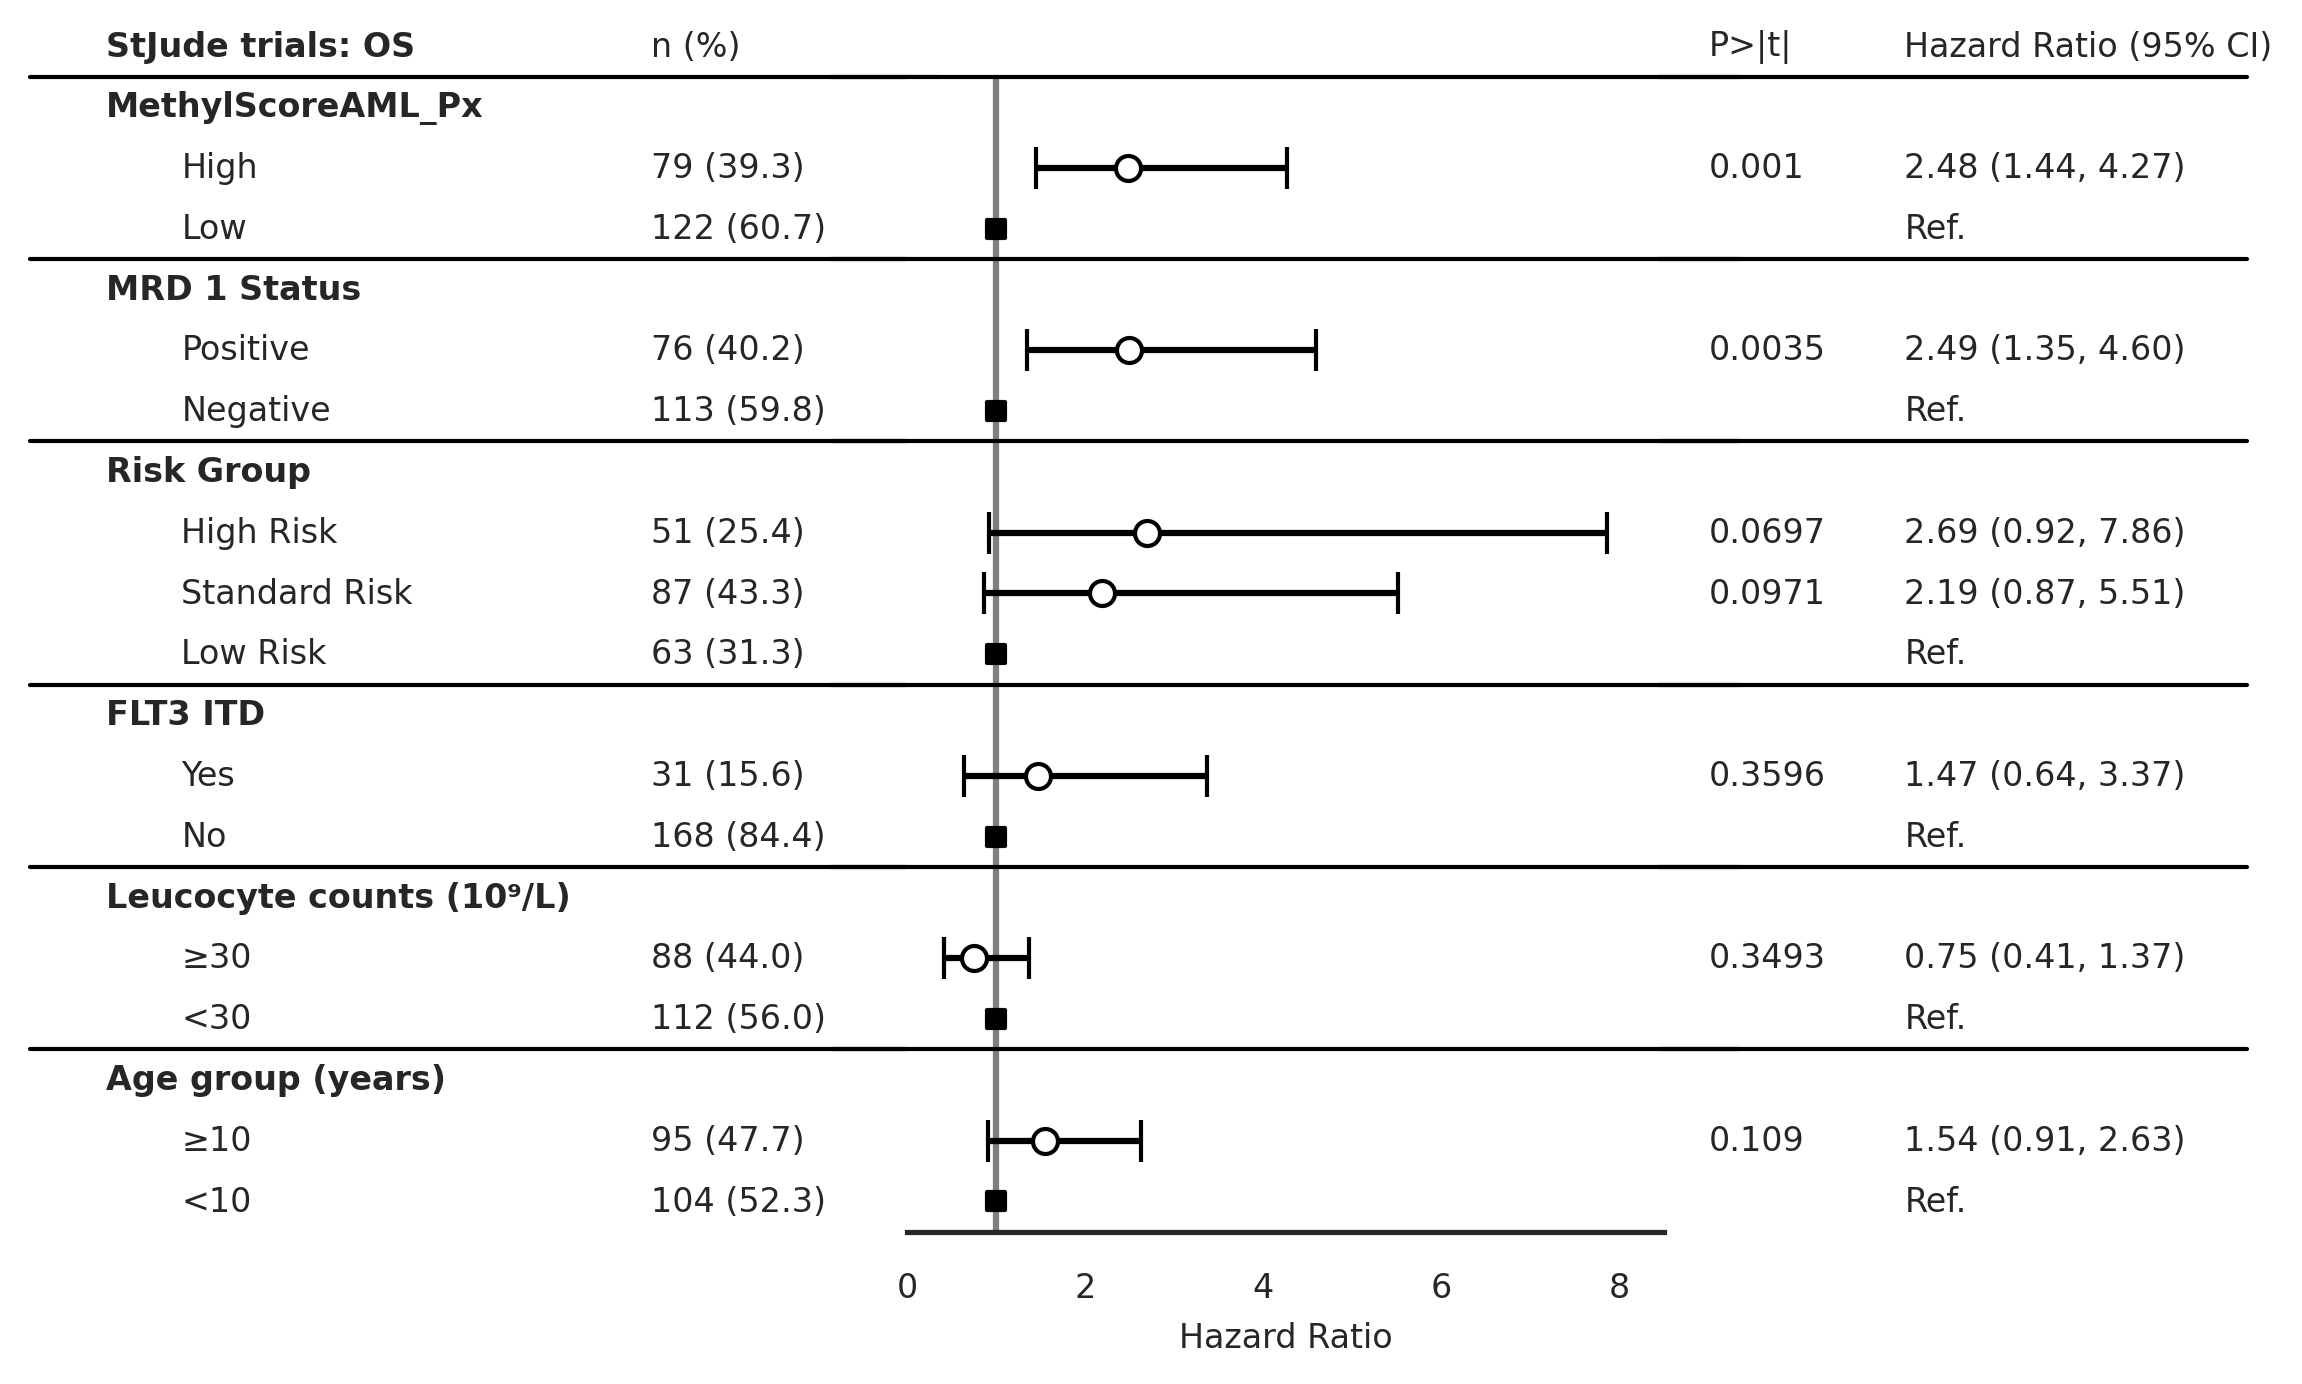

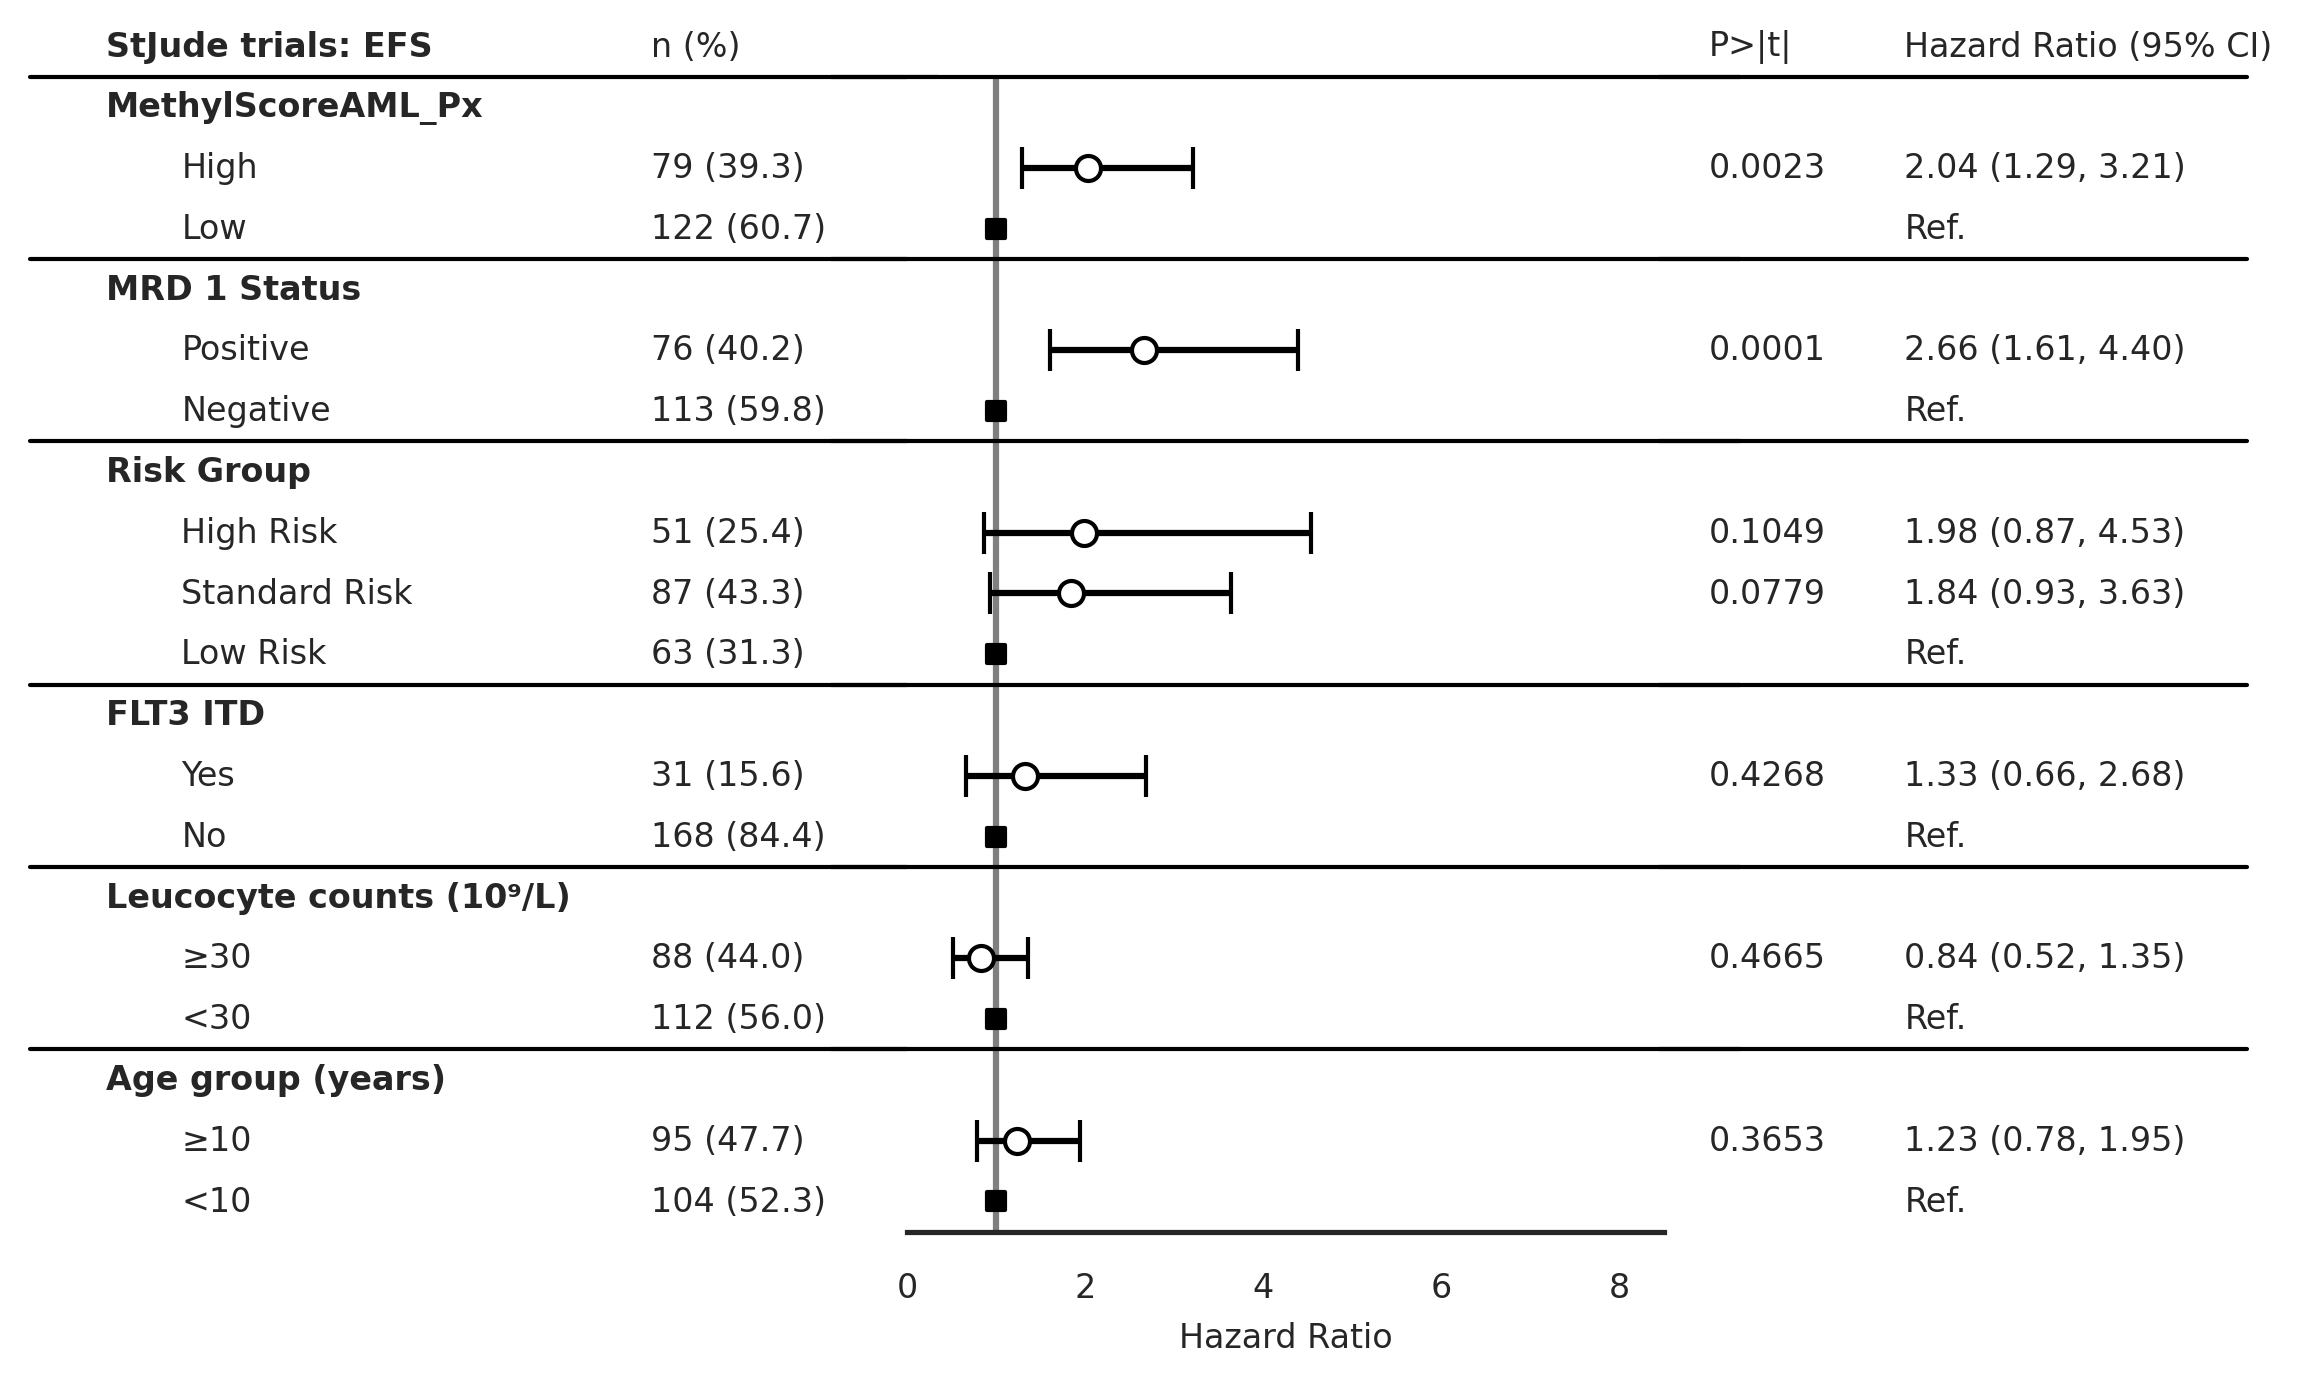

In [9]:
draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

#### Without MRD 1

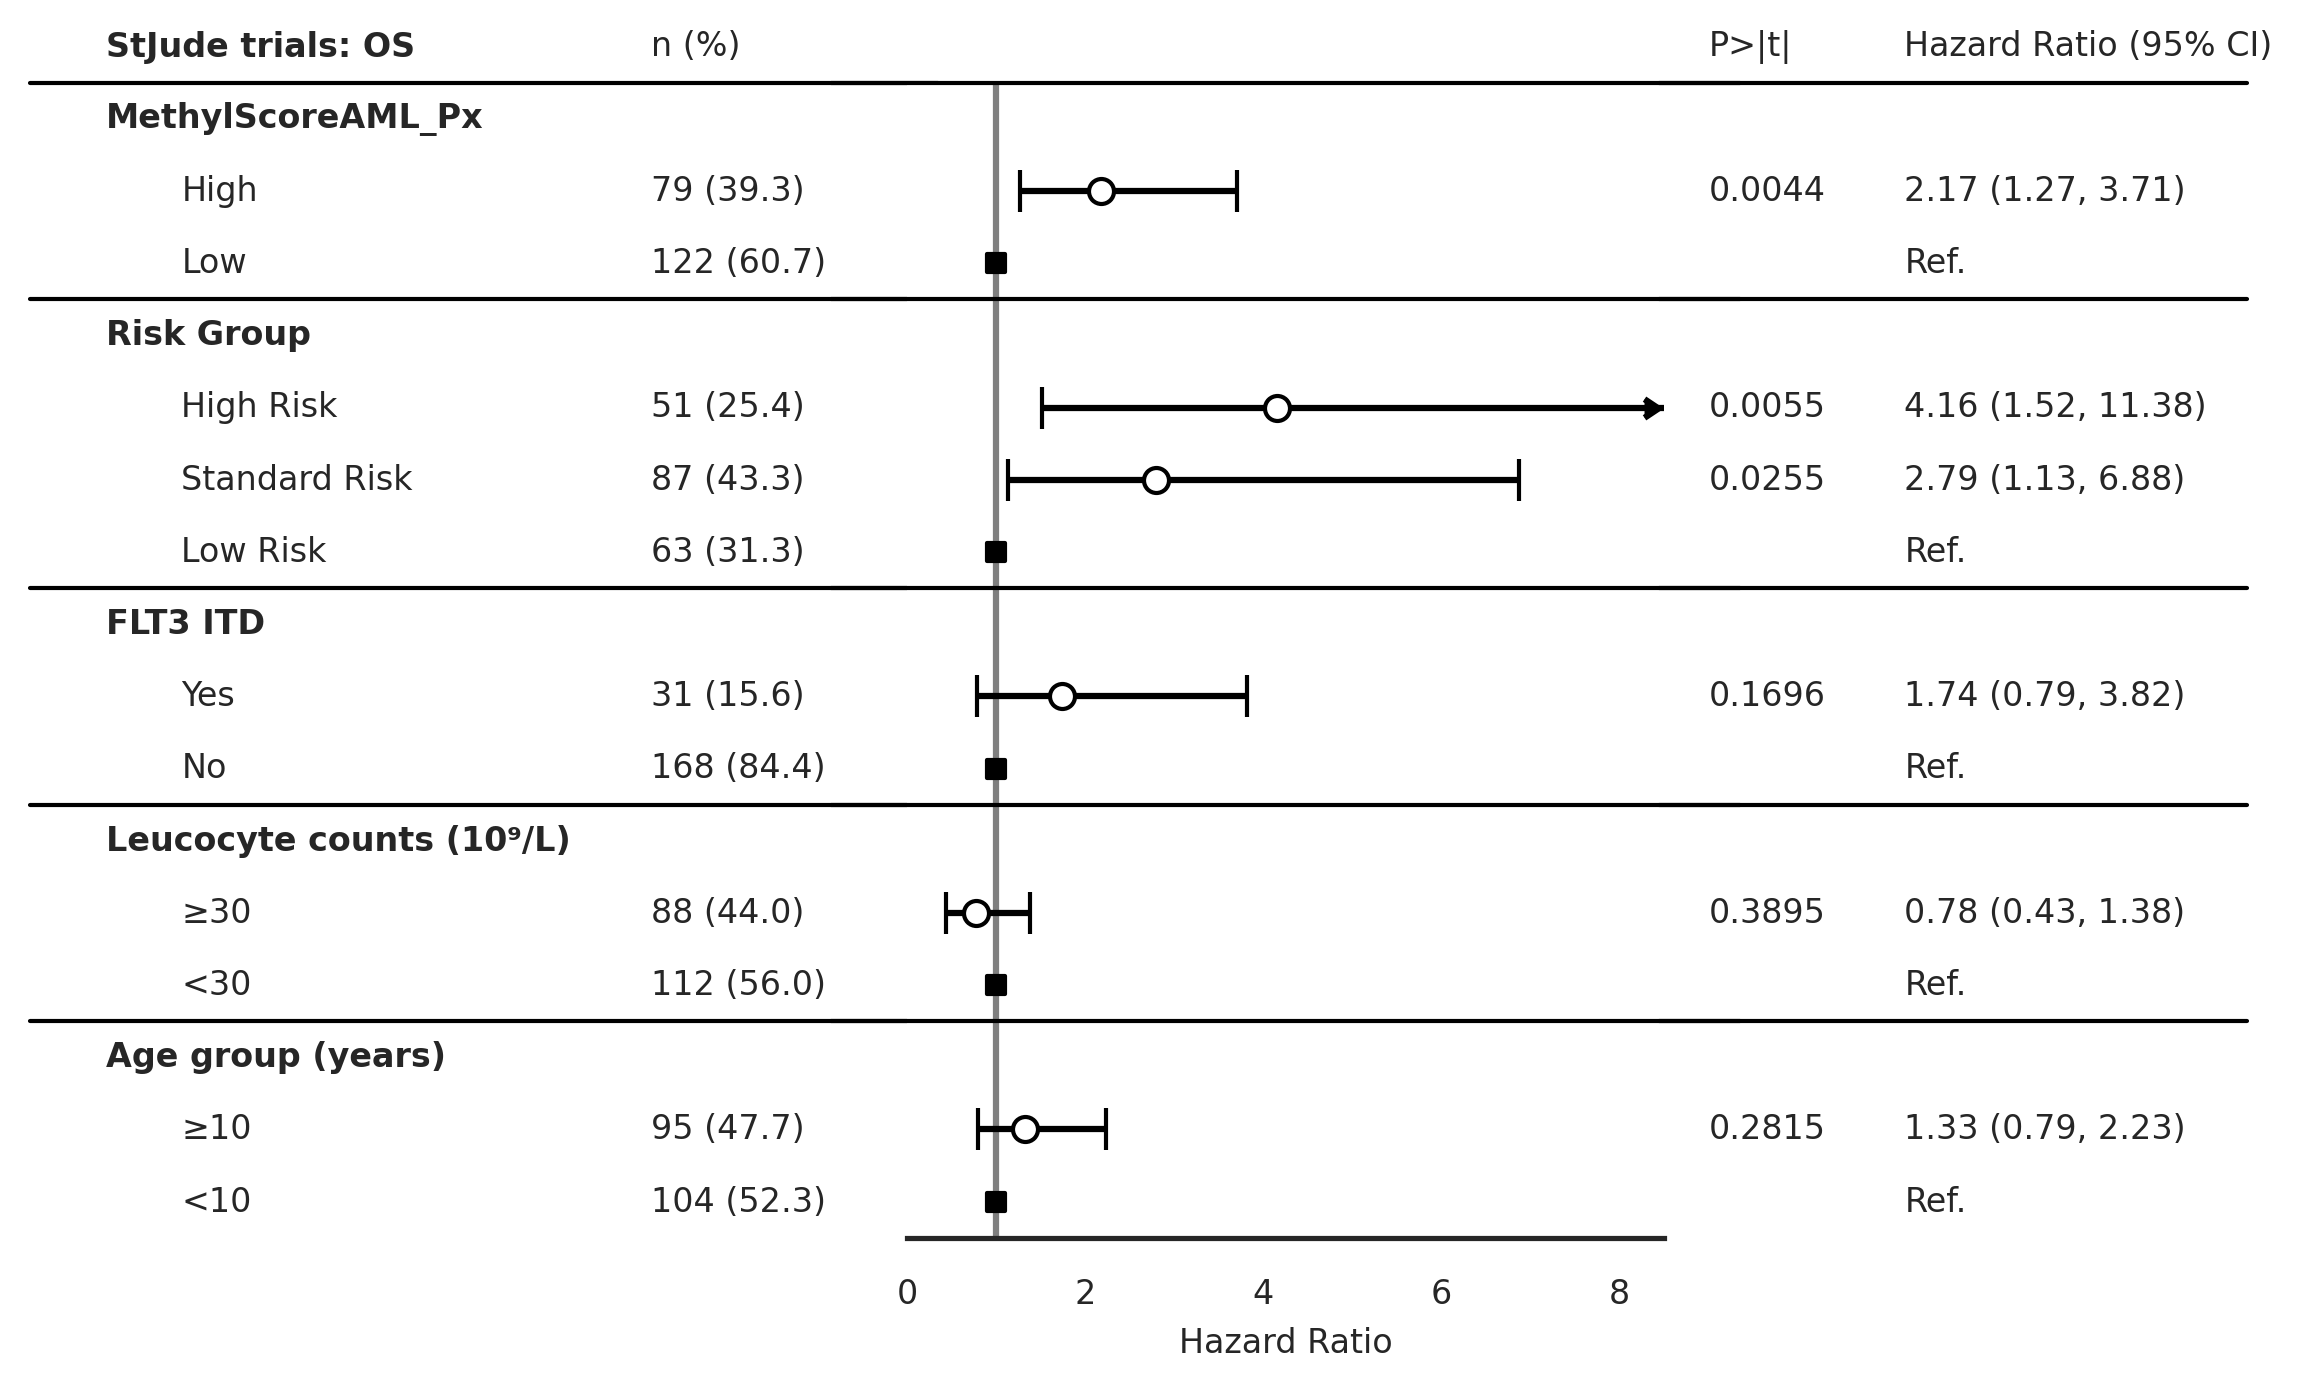

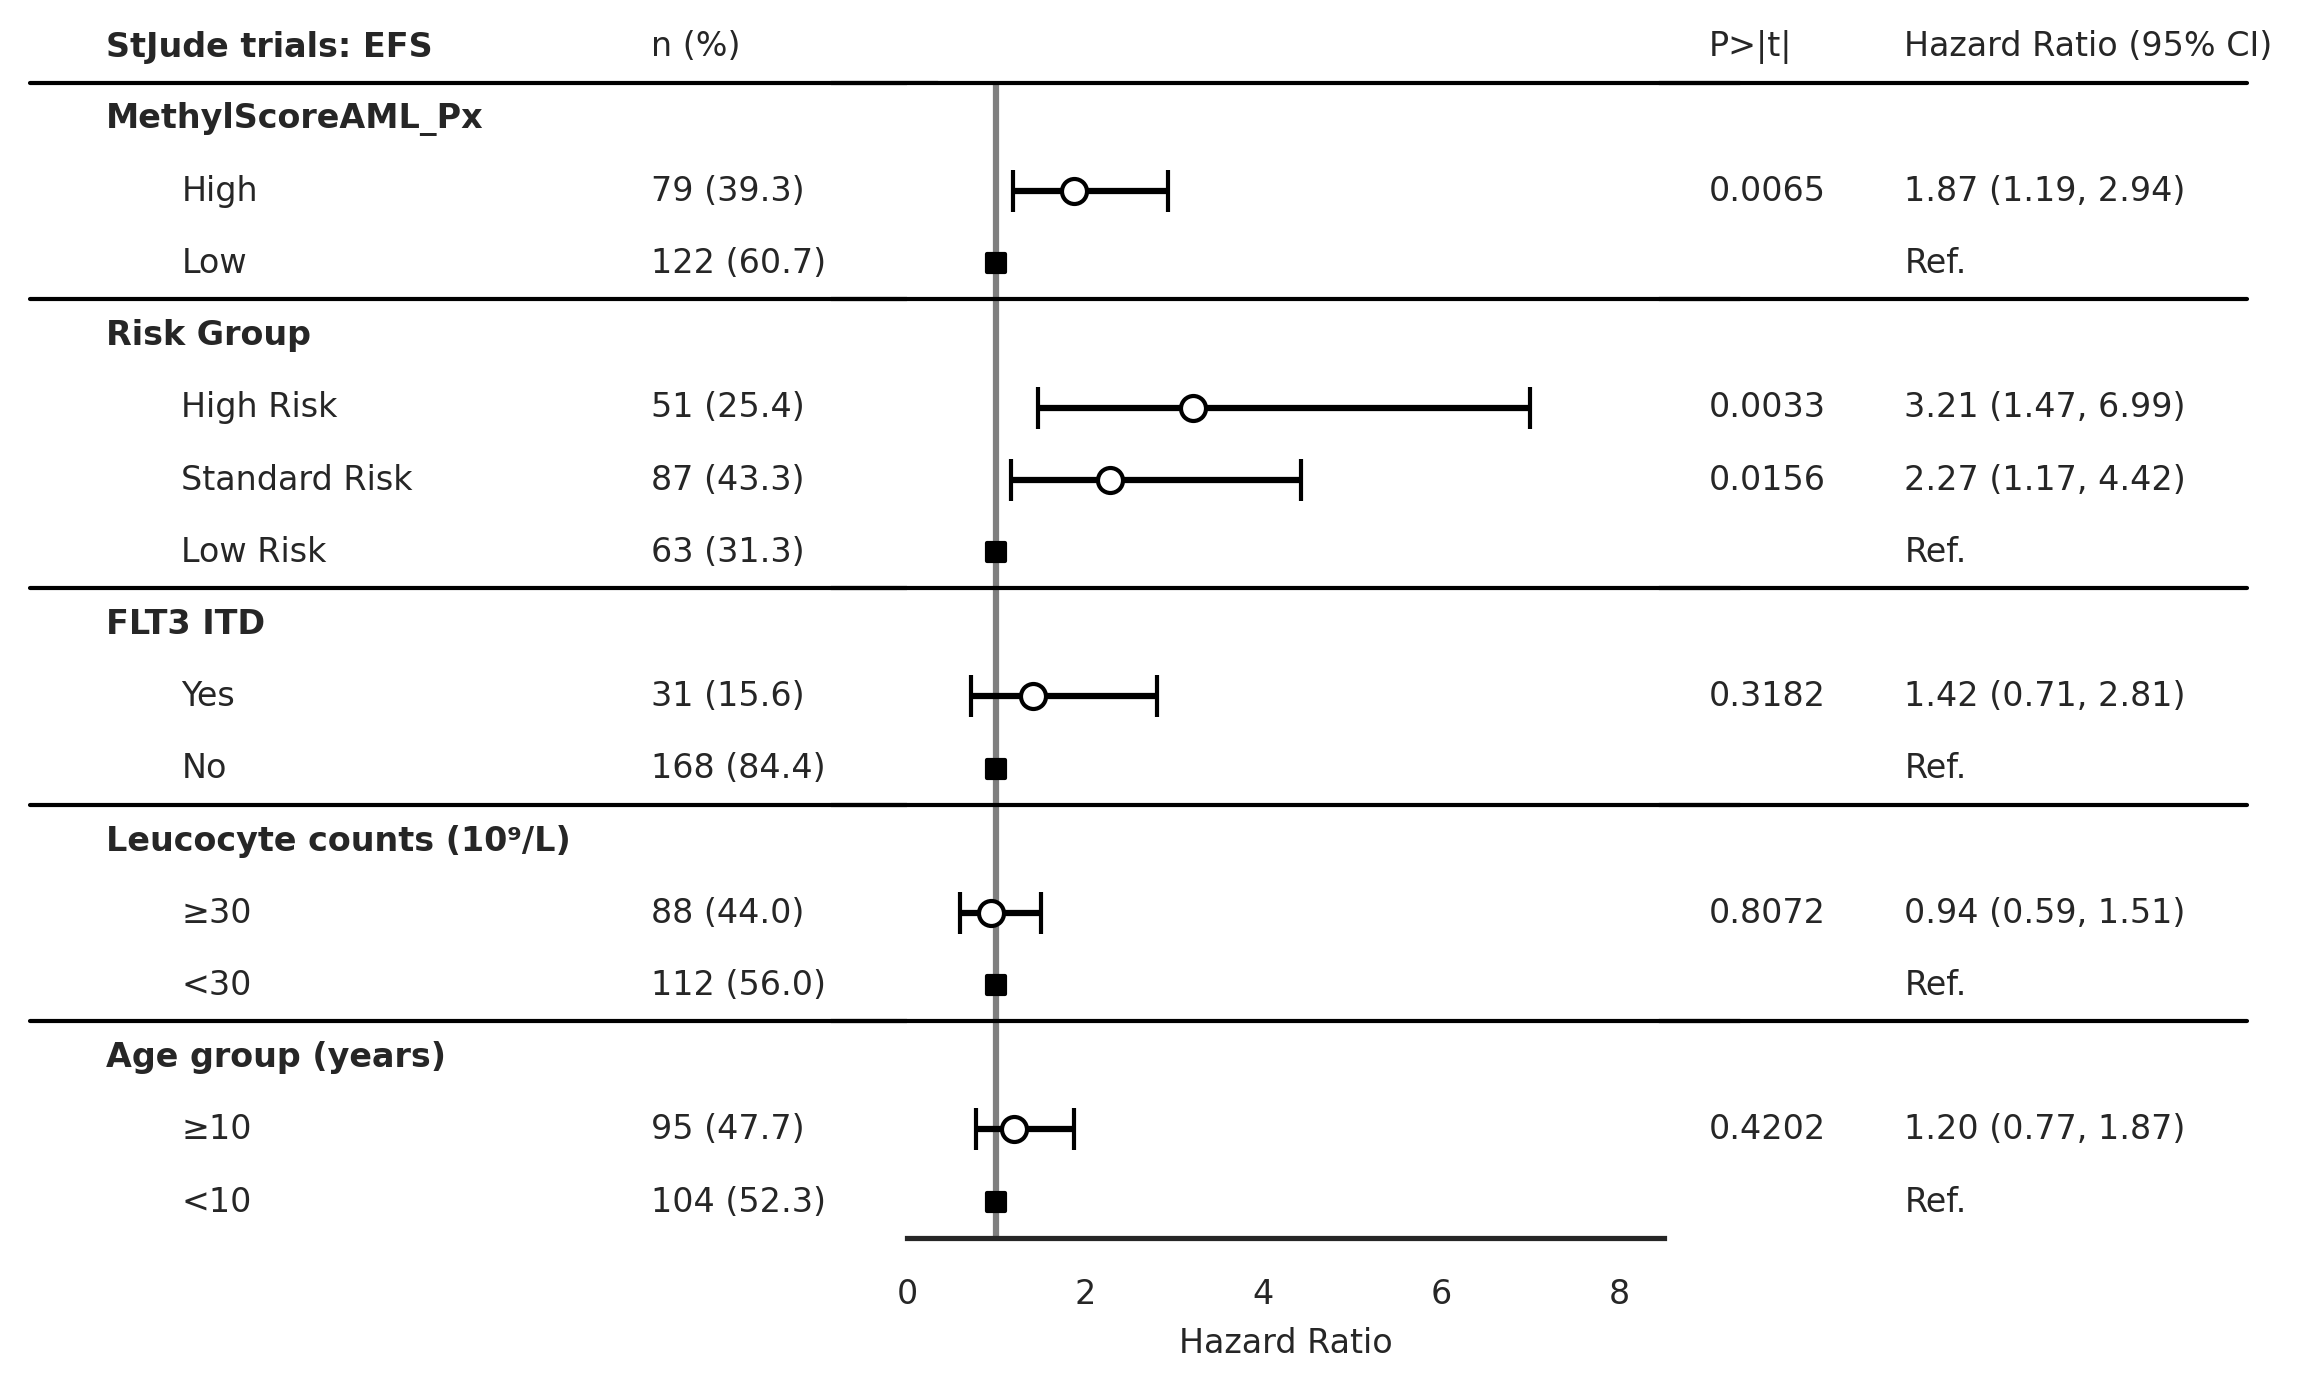

In [10]:
draw_forest_plot_noMRD(time='os.time',
                    event='os.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot_noMRD(time='efs.time',
                    event='efs.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

### ROC AUC

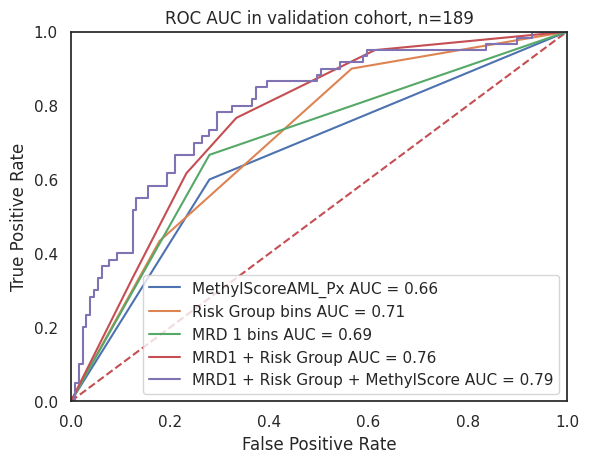

In [11]:
# Your current preprocessing
df_test['Risk Group bins'] = df_test['Risk Group'].replace({'Low Risk':0, 'Standard Risk':0.5, 'High Risk':1})
df_test['MRD 1 bins'] = df_test['MRD 1 Status'].replace({'Negative':0, 'Positive':1})
df_test2 = df_test[['os.evnt', 'MethylScoreAML_Px_cat_bin', 'Risk Group bins', 'MRD 1 bins']].dropna()

# rename column `MethylScoreAML_Px_cat_bin` to `MethylScoreAML Px`
df_test2 = df_test2.rename(columns={'MethylScoreAML_Px_cat_bin':'MethylScoreAML_Px'})

# Add new columns based on standardized values
df_test2['MRD1 + Risk Group'] = df_test['MRD 1 bins'] + df_test['Risk Group bins']
df_test2['MRD1 + Risk Group + MethylScore'] = df_test['MRD 1 bins'] + df_test['Risk Group bins'] + df_test['MethylScoreAML_Px']


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_auc(df, score_columns, outcome_column, trial_name='validation cohort'):
    """
    Plots the ROC AUC curves for multiple models given a dataframe and multiple score columns.
    
    Parameters:
    - df (pd.DataFrame): Dataframe containing the score and outcome columns.
    - score_columns (list of str): List of names of columns that contain the scores.
    - outcome_column (str): The name of the column that contains the true outcomes.
    
    Returns:
    None
    """
    
    plt.figure()
    plt.title('ROC AUC in ' + trial_name + ', n={}'.format(len(df)))
    
    # plot random guessing line
    plt.plot([0, 1], [0, 1], 'r--')

    # binarize the outcome variable
    lb = LabelBinarizer()
    lb.fit(df[outcome_column])
    y = lb.transform(df[outcome_column])
    
    # Loop over score_columns to plot multiple ROC curves
    for score_column in score_columns:
        
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y, df[score_column])
        roc_auc = auc(fpr, tpr)
        
        # plot ROC curve for this score_column
        plt.plot(fpr, tpr, label=f'{score_column} AUC = %0.2f' % roc_auc)

    # set x and y limits
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # set x and y labels
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # add legend
    plt.legend(loc='lower right')
    plt.show()

# Example Usage:
score_columns = ['MethylScoreAML_Px', 'Risk Group bins', 'MRD 1 bins', 'MRD1 + Risk Group', 'MRD1 + Risk Group + MethylScore']
outcome_column = 'os.evnt'
plot_roc_auc(df_test2, score_columns, outcome_column)



### Box Plots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High Risk vs. Standard Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:9.278e-01 Stat=1.034e+00
Standard Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:2.635e-10 Stat=4.208e+01
High Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:1.812e-08 Stat=3.382e+01


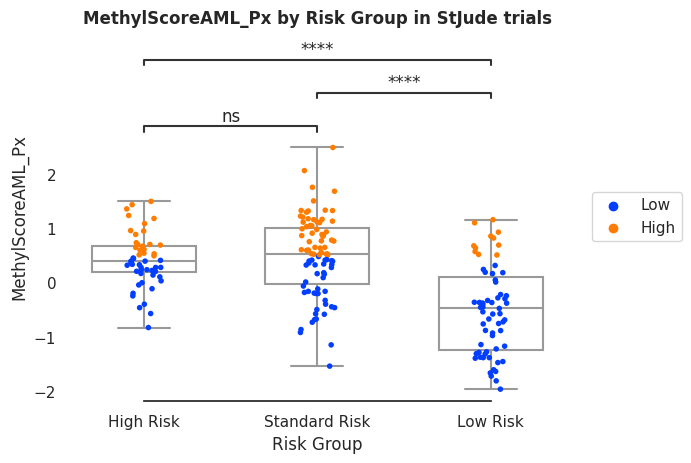

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Positive vs. Negative: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:1.323e-01 Stat=2.265e+00


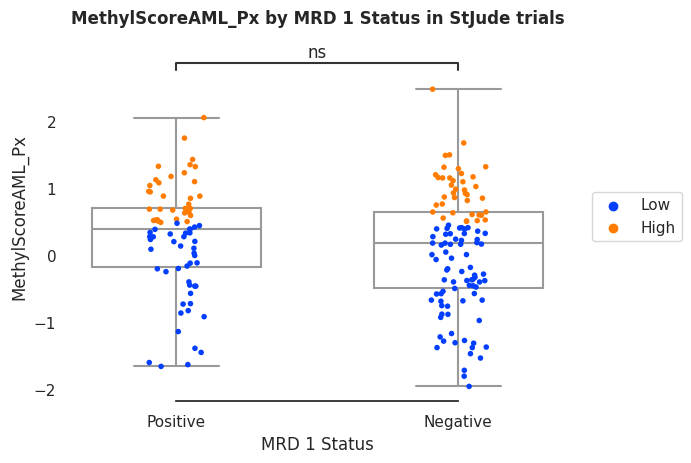

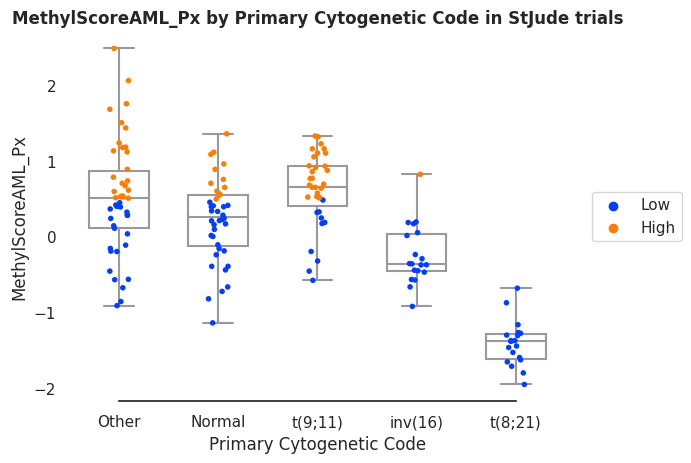

In [12]:
draw_boxplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
                order=['Positive','Negative'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

### Stacked Bar Plots

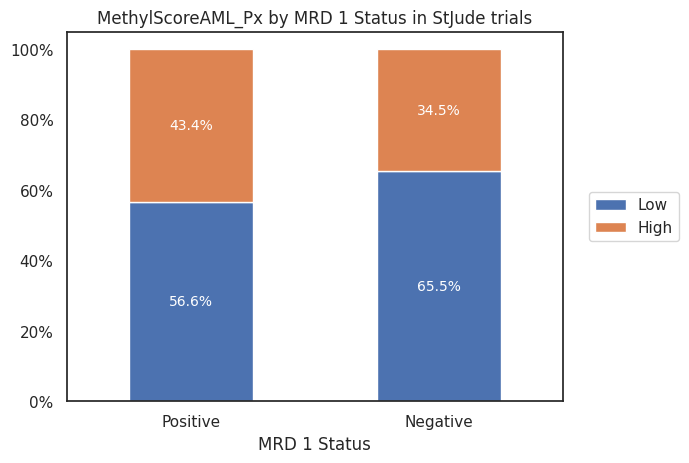

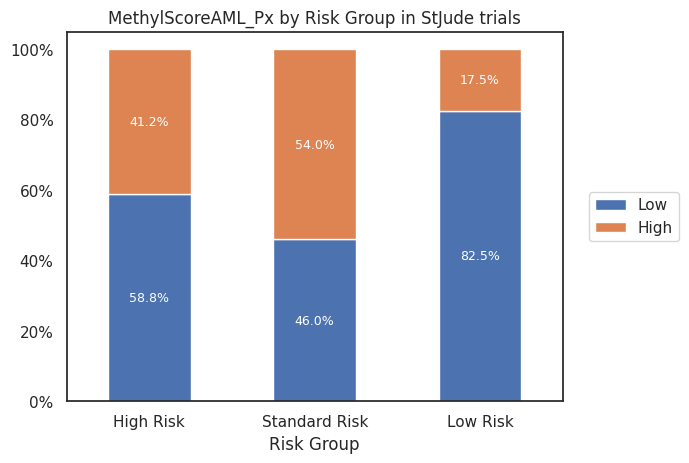

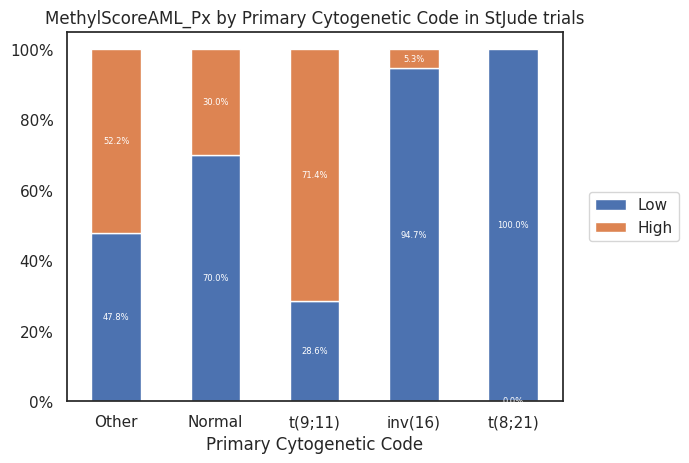

In [13]:
draw_stacked_barplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='StJude trials', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=6)



### Patient Characteristics Table

#### Overall study population

In [14]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD','Treatment Arm']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_cohort.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','Validation Cohort'])

MethylScoreAML_Px,,Missing,Validation Cohort
n,,,201
"Age (years), mean (SD)",,2,8.8 (6.0)
"Age group (years), n (%)",≥10,2,95 (47.7)
,<10,,104 (52.3)
"Sex, n (%)",Female,0,87 (43.3)
,Male,,114 (56.7)
"Race or ethnic group, n (%)",White,2,143 (71.9)
,Black or African American,,32 (16.1)
,Asian,,1 (0.5)
,Native Hawaiian or other Pacific Islander,,2 (1.0)


#### Including both discovery and validation cohorts

In [15]:
# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

discovery_clinical_data['Age (years)'] = discovery_clinical_data['Age (years)'].astype(float)

px = discovery_clinical_data.loc[ewas_top_cpgs.index]

dx = discovery_clinical_data
# [~discovery_clinical_data['ELN 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
#                                        'Myeloid leukaemia associated with Down syndrome',
#                                        'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]
dx = dx[~dx['WHO 2022 Diagnosis'].isna()]

# Use only samples from df_index
dx = dx[dx.index.isin(pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=1).index)]

# join discovery clinical data with validation clinical data
all_cohorts = pd.concat([dx, px, validation_clinical_data],
                         axis=0, keys=['MethylScoreAML Dx Discovery','MethylScoreAML Px Discovery' ,'Validation'],
                         names=['cohort']).reset_index()


columns = ['Age group (years)','Sex', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)',
            'Risk Group','FLT3 ITD', 'Treatment Arm','Clinical Trial']

mytable_cog = TableOne(all_cohorts, columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                                groupby='cohort')

mytable_cog.to_excel('../data/tableone_both_cohorts.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",score_name,'Validation','p-value','Statistical Test']
)

,,MethylScoreAML Dx Discovery,MethylScoreAML Px Discovery,Validation
n,,2236,940,201
"Age group (years), n (%)",≥10,511 (47.1),458 (48.7),95 (47.7)
,<10,573 (52.9),482 (51.3),104 (52.3)
"Sex, n (%)",Female,696 (50.5),466 (49.6),87 (43.3)
,Male,683 (49.5),474 (50.4),114 (56.7)
"MRD 1 Status, n (%)",Positive,276 (29.3),258 (31.4),76 (40.2)
,Negative,666 (70.7),563 (68.6),113 (59.8)
"Leucocyte counts (10⁹/L), n (%)",≥30,568 (52.4),463 (49.3),88 (44.0)
,<30,516 (47.6),477 (50.7),112 (56.0)
"Risk Group, n (%)",High Risk,139 (11.7),128 (13.8),51 (25.4)


#### By MethylScore category

In [16]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_methylscoreaml_px.csv')
mytable_cog.to_excel('../data/tableone_validation_methylscoreaml_px.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

MethylScoreAML_Px,,Missing,High,Low,p-value,Statistical Test
n,,,122,79,,
"Age (years), mean (SD)",,2,9.6 (5.5),7.5 (6.4),0.021,Two Sample T-test
"Age group (years), n (%)",≥10,2,65 (53.7),30 (38.5),0.050,Chi-squared
,<10,,56 (46.3),48 (61.5),,
"Sex, n (%)",Female,0,48 (39.3),39 (49.4),0.209,Chi-squared
,Male,,74 (60.7),40 (50.6),,
"Race or ethnic group, n (%)",White,2,87 (71.9),56 (71.8),0.721,Chi-squared (warning: expected count < 5)
,Black or African American,,21 (17.4),11 (14.1),,
,Asian,,,1 (1.3),,
,Native Hawaiian or other Pacific Islander,,1 (0.8),1 (1.3),,


## Watermark

In [17]:
%load_ext watermark

In [18]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.2
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

